<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/Audio/Audio_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio classification
### Types of audio classification
**Acoustic data classification:** 
- Classification that identifies where an audio signal was recorded (e.g. restaurants, schools, homes, offices, streets, etc. 
- Use of acoustic data classification inbuilding and maintaining of sound libraries for audio multimedia, ecosystem monitoring.

**Environmental sound classification:** 
- For example, recognizing urban sound samples such as car horns, roadwork, sirens, human voices, etc. This is used in security systems to detect sounds like breaking glass.

**Music classification:** 
- Classifying music based on factors such as genre or instruments played. - Organizing audio libraries by genre, improving recommendation algorithms, and discovering trends and listener preferences.

**Natural language utterance classification:** 
- This is the classification of natural language recordings based on language spoken, dialect, semantics, or other language features, classification of human speech. 
- Chatbots and virtual assistants, machine translation and text to speech applications.

In [1]:
import pandas as pd
import numpy as np
import librosa.display as ld
import librosa

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.cubehelix_palette(start=.5, rot=-.5)
sns.set_palette(palette=palette)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
%matplotlib inline

In [3]:
dataset = pd.read_pickle('/content/drive/MyDrive/analyzed_esc50.pkl')
dataset.head()

,filename,category,audio
0,1-100032-A-0.wav,dog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1-100038-A-14.wav,chirping_birds,"[-0.029419238, -0.13688716, -0.08337966, -0.03..."
2,1-100210-A-36.wav,vacuum_cleaner,"[-0.006616091, -0.011910033, -0.0030402767, -0..."
3,1-100210-B-36.wav,vacuum_cleaner,"[0.37941363, 0.29618832, 0.17503375, 0.7082076..."
4,1-101296-A-19.wav,thunderstorm,"[-0.0003722518, -0.00077188, 0.0002965101, 0.0..."


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2000 non-null   object
 1   category  2000 non-null   object
 2   audio     2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [5]:
dataset.audio[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

### Data Preperation

In [6]:
classes = dataset['category'].unique()
len(classes)

50

#### Extracting MFCCs for each audio
> Apply Normalization

In [7]:
from sklearn.preprocessing import minmax_scale as normalize

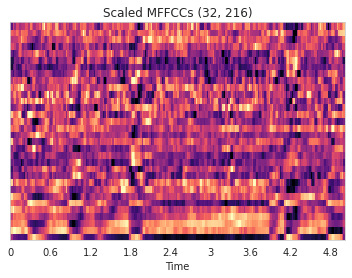

In [8]:
f, ax = plt.subplots()

mfccs = librosa.feature.mfcc(dataset.audio[8], n_mfcc=32)
scaled_mfccs = normalize(mfccs, axis=1)
ld.specshow(scaled_mfccs, x_axis='time', ax=ax)
ax.set_title(f'Scaled MFFCCs {scaled_mfccs.shape}');

In [9]:
features_config = {'sampling_rate': 22050,
                   'n_mfcc': 32,
                   'audio_length': 22050 * 5,
                   'mfcc_shape': (32, 216)
                   }

In [10]:
X = np.empty(shape=(dataset.shape[0], *features_config['mfcc_shape']))
for i, y in enumerate(dataset.audio.values):
  x = librosa.feature.mfcc(y, features_config['sampling_rate'], n_mfcc=features_config['n_mfcc'])
  x = normalize(x)
  X[i] = x

In [11]:
X = X.reshape((*X.shape, 1))

#### Encoding classes

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
encoder = LabelEncoder()
y = encoder.fit_transform(dataset['category'].values)
y.shape

(2000,)

#### Data Splitting

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.15, random_state=42)

X_train.shape, y_train.shape

((1700, 32, 216, 1), (1700,))

### Model 

In [16]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *

#### 2D Convolutional Network

In [23]:
input_shape = X.shape[1:]

model = keras.Sequential([
                  Input(shape=input_shape),

                  Conv2D(16, kernel_size=(3,3), padding='same'),
                  BatchNormalization(),
                  Activation('relu'),
                  MaxPool2D(pool_size=(2,2)), # output 16 x 108 x 16

                  Conv2D(32, kernel_size=(3, 3), padding='same'),
                  BatchNormalization(),
                  Activation('relu'),
                  MaxPool2D(pool_size=(2,2)), # output 8 x 56 x 32

                  Conv2D(64, kernel_size=(3, 3), padding='same'),
                  BatchNormalization(),
                  Activation('relu'),
                  MaxPool2D(pool_size=(2,2)), # output 4 x 28 x 64

                  Conv2D(128, kernel_size=(3, 3), padding='same'),
                  BatchNormalization(),
                  Activation('relu'),
                  MaxPool2D(pool_size=(2,2)), # output 2 x 14 x 128

                  Flatten(),
                  Dense(1024, activation='relu'),
                  Dense(512, activation='relu'),
                  Dense(len(classes), activation='softmax')
  ])

In [24]:
lr = 3e-5
loss = 'sparse_categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss, metrics=metrics)

In [25]:
epochs = 12
batch_size = 12
tf.config.run_functions_eagerly(True)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/12
142/142 [==============================] - 31s 219ms/step - loss: 3.6361 - accuracy: 0.0735 - val_loss: 3.9218 - val_accuracy: 0.0200
Epoch 2/12
142/142 [==============================] - 31s 217ms/step - loss: 3.0444 - accuracy: 0.1935 - val_loss: 3.9575 - val_accuracy: 0.0267
Epoch 3/12
142/142 [==============================] - 31s 218ms/step - loss: 2.7356 - accuracy: 0.2629 - val_loss: 3.6898 - val_accuracy: 0.0500
Epoch 4/12
142/142 [==============================] - 32s 226ms/step - loss: 2.4603 - accuracy: 0.3453 - val_loss: 3.0826 - val_accuracy: 0.1533
Epoch 5/12
142/142 [==============================] - 32s 226ms/step - loss: 2.2068 - accuracy: 0.3900 - val_loss: 2.7238 - val_accuracy: 0.2500
Epoch 6/12
142/142 [==============================] - 32s 228ms/step - loss: 1.9794 - accuracy: 0.4582 - val_loss: 2.5656 - val_accuracy: 0.2833
Epoch 7/12
142/142 [==============================] - 31s 218ms/step - loss: 1.7959 - accuracy: 0.5182 - val_loss: 2.4427 - val_ac

In [26]:
def visualize_performance(history, metric):
  plt.title(f'Model {metric}')
  plt.plot(history[metric])
  plt.plot(history['val_'+ metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend(['train_' + metric, 'val_' + metric])
  plt.title(f'Model {metric}')

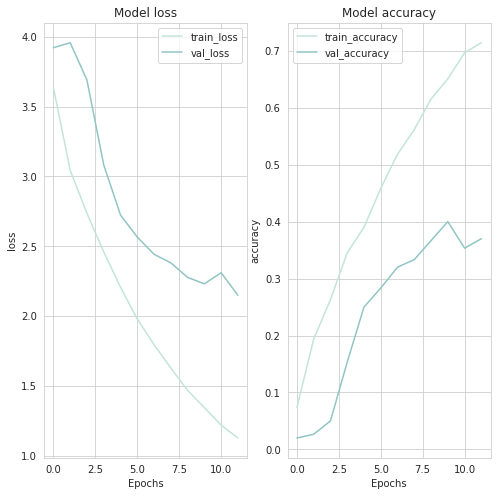

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
visualize_performance(history.history, 'loss')
plt.subplot(1, 2, 2)
visualize_performance(history.history, 'accuracy')

In [29]:
# https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html